#  Recycler Simulation

In [18]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('talk')

import copy

from scipy.constants import c, e, m_p

import PyHEADTAIL

from FERMImachines import RR

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.impedances.wakes import CircularResistiveWall, CircularResonator, WakeField, WakeTable

0.5


c:\Users\bengl\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
1.0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
2.0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4.0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
5.0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000


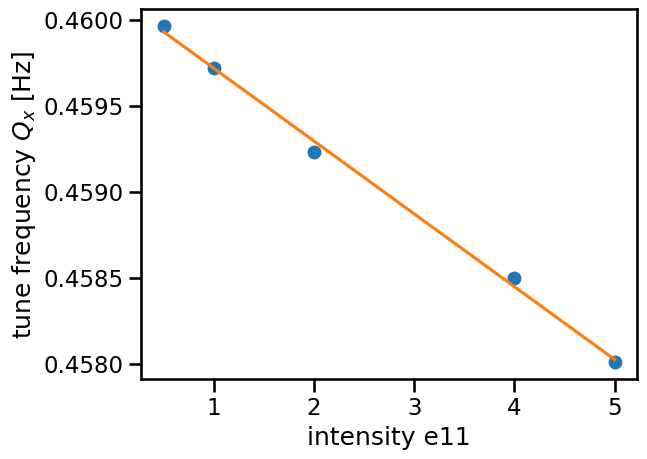

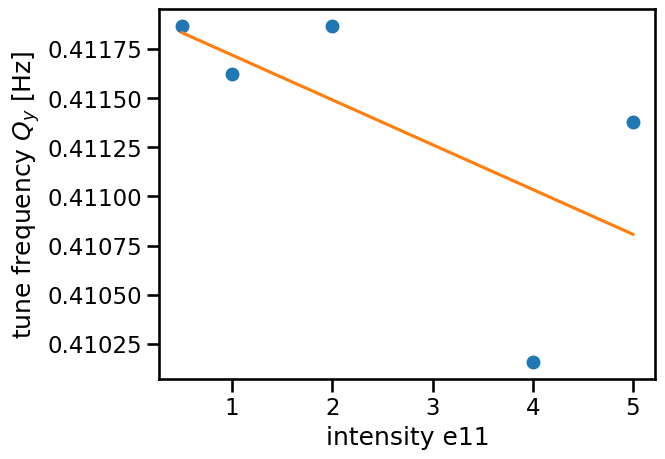

In [19]:
intensities =np.array([0.5,1,2,4,5])
tune_freqs_x = []
tune_freqs_y = []
n_turns = 2048*2

for i, intensity in enumerate(intensities):
    print(intensity)
    machine = RR(n_segments=1, machine_configuration='53MHz', 
                optics='smooth', printer=PyHEADTAIL.general.printers.SilentPrinter())

    C = machine.circumference

    epsn_x = epsn_y = 2.5e-6*np.pi # in [m.rad]

    bunch = machine.generate_6D_Gaussian_bunch_matched(
        n_macroparticles=int(5e4), intensity=intensity*1e11, 
        epsn_x=epsn_x, epsn_y=epsn_y, sigma_z=0.57)

    n_sigma_z = 2
    n_slices = 50
    uniform_bin_slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

    #wake_table = CircularResonator(R_shunt=1e6, frequency=1e9, Q=1)

    #wakefile = r'C:\\Users\bengl\Documents\\PyHEADTAIL-playground\\RR_fullWake_resistiveWall_PyHTConvention.dat'
    #wake_table = WakeTable(wakefile, ['time', 'dipole_x', 'dipole_y', 'quadrupole_x', 'quadrupole_y','nonsense'],n_turns_wake=5)   # Follow the order of the columns in the wake file here. If you want to exclude a component, change the name e.g. for the dipole y to 'no_dipole_y'.
    #wake_field = WakeField(uniform_bin_slicer, wake_table) #, wake_table_k, wake_table_k)
    
    #wake_table = CircularResistiveWall(pipe_radius=5e-2, resistive_wall_length=C, conductivity=3e4, dt_min=1e-3/c, beta=bunch.beta, n_turns_wake=100)
    
    R_shunt = 10.2e5   # Shunt impedance [Ohm/m]
    frequency = 1.3e9   # Resonance frequency [Hz]
    Q = 1   # Quality factor

    wake_table = CircularResonator(R_shunt,frequency,Q)
    wake_field = WakeField(uniform_bin_slicer, wake_table)
    machine.one_turn_map.append(wake_field)
    
    m_x = []
    m_y = []
    
    for i in range(n_turns):
        machine.track(bunch)
        m_x.append(bunch.mean_x())
        m_y.append(bunch.mean_y())
        if i % 100 == 0:
            print(i)

    m_x = np.array(m_x)
    m_y = np.array(m_y)

    max_index = np.argmax(np.abs(np.fft.rfft(m_x)))
    freqs = np.fft.rfftfreq(n_turns)
    max_freq = freqs[max_index]

    tune_freqs_x.append(max_freq)

    max_index = np.argmax(np.abs(np.fft.rfft(m_y)))
    freqs = np.fft.rfftfreq(n_turns)
    max_freq = freqs[max_index]

    tune_freqs_y.append(max_freq)

plt.plot(intensities, tune_freqs_x, 'o')
plt.xlabel('intensity e11')
plt.ylabel('tune frequency $Q_x$ [Hz]')
a,b = np.polyfit(intensities, tune_freqs_x, 1)
plt.plot(intensities,  intensities*a+b, label='linear fit')
plt.show()

plt.plot(intensities, tune_freqs_y, 'o')
plt.xlabel('intensity e11')
plt.ylabel('tune frequency $Q_y$ [Hz]')
a,b = np.polyfit(intensities, tune_freqs_y, 1)
plt.plot(intensities,  intensities*a+b, label='linear fit')
plt.show()

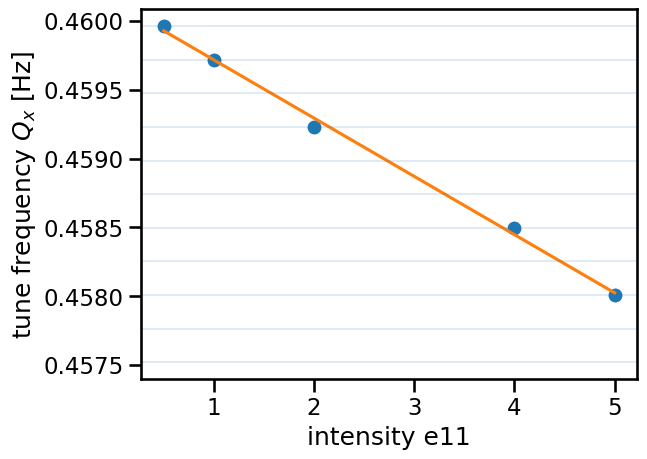

In [20]:
freqs = np.fft.rfftfreq(n_turns)
plt.plot(intensities, tune_freqs, 'o')
plt.xlabel('intensity e11')
plt.ylabel('tune frequency $Q_x$ [Hz]')
a,b = np.polyfit(intensities, tune_freqs, 1)
plt.plot(intensities,  intensities*a+b, label='linear fit')
mask = (freqs>0.4575) & (freqs<0.46)
freqs = freqs[mask]
[plt.axhline(s, linewidth=0.2) for s in freqs]
plt.show()

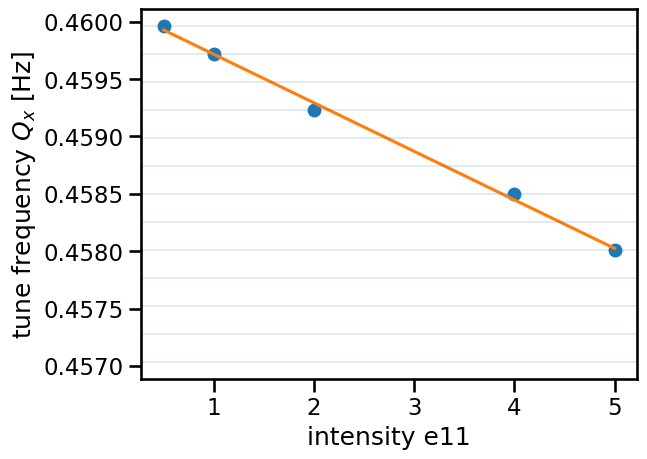

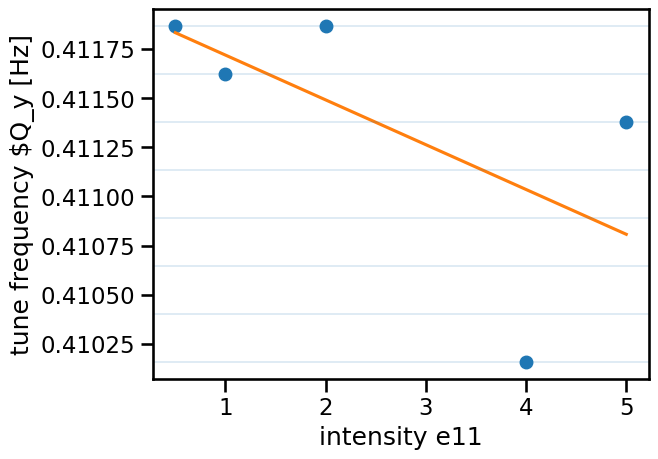

In [28]:
freqs = np.fft.rfftfreq(n_turns)
plt.plot(intensities, tune_freqs_x, 'o')
plt.xlabel('intensity e11')
plt.ylabel('tune frequency $Q_x$ [Hz]')
a,b = np.polyfit(intensities, tune_freqs_x, 1)
plt.plot(intensities,  intensities*a+b, label='linear fit')
mask = (freqs>0.457) & (freqs<0.46)
freqs = freqs[mask]
[plt.axhline(s, linewidth=0.2) for s in freqs]
plt.show()

freqs = np.fft.rfftfreq(n_turns)
plt.plot(intensities, tune_freqs_y, 'o')
plt.xlabel('intensity e11')
plt.ylabel('tune frequency $Q_y [Hz]')
a,b = np.polyfit(intensities, tune_freqs_y, 1)
plt.plot(intensities,  intensities*a+b, label='linear fit')
mask = (freqs>0.41) & (freqs<0.412)
freqs = freqs[mask]
[plt.axhline(s, linewidth=0.2) for s in freqs]
plt.show()